<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3a_OSI_SAF_sea_ice_mapping_Ice_Concentration.ipynb" target="_blank"><< Exploring OSI SAF sea ice file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_sea_ice_mapping_Ice_Edge.ipynb" target="_blank">Mapping OSI SAF sea ice edge >></a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-sea-ice/HEAD?labpath=1_OSI_SAF_sea_ice_introductory%2F1_3a_OSI_SAF_sea_ice_mapping_ice_concentration.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF sea ice parameters : Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1_OSI_SAF_sea_ice_FTP_data_access.ipynb" target="_blank">1_1a_OSI_SAF_sea_ice_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3a Mapping OSI SAF sea ice concentration 
### Data used 

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| Global Sea Ice Concentration (SSMIS) | EO:EUM:DAT:DMSP:OSI-401-B | <a href="https://osi-saf.eumetsat.int/products/osi-401-b" target="_blank">Description</a>   | OSI-401-B |
| Global Sea Ice Concentration (AMSR-2) | EO:EUM:DAT:GCOM:OSI-408 | <a href="https://osi-saf.eumetsat.int/products/osi-408-a" target="_blank">Description</a> | OSI-408-a | 
| Level 2 PMW sea ice concentration | - | <a href="https://osi-saf.eumetsat.int/products/osi-410-a" target="_blank">Description</a> | OSI-410-a | 
| Global Sea Ice Concentration interim climate data record, release 3 | EO:EUM:DAT:0645 | <a href="https://osi-saf.eumetsat.int/products/osi-430-a" target="_blank">Description</a> | OSI-430-a 
| Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3 | EO:EUM:DAT:0826 | <a href="https://osi-saf.eumetsat.int/products/osi-450-a" target="_blank">Description</a> | OSI-450-a 
| Global Sea Ice Concentration climate data record (AMSR), release 3 | EO:EUM:DAT:0797 | <a href="https://osi-saf.eumetsat.int/products/osi-458" target="_blank">Description</a> | OSI-458 

### Learning outcomes

At the end of this notebook you will know;
* How to open Sea Ice Concentration netcdf
* Map Sea Ice Concentration using cartopy 

<div class="alert alert-info" role="alert">

## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Map - Sea Ice Concentration - Northern Hemisphere](#section1)
 1. [Map - Sea Ice Concentration - Southern Hemisphere](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports 
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import cmcrameri                   # scientific colormaps for data visualisation
import numpy as np                 # a library that supports array manipulation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

##
<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_ice_conc` create a plot figure of sea ice concentration product available in the directory **dir** with a specific output projection and a specific region of the globe if given.

In [2]:
def mapping_ice_conc(directory, data_projection, output_projection, cmap, ax=None, ice_shelves=None, title="", region=None):
    """
    Function to map Sea Ice Concentration. 

    Args:
        dir (string)        : the directory where files are
        data_projection     : the input projection of data
        output_projection   : the output projection to plot map
        cmap                : color palette
        ax                  : axes of the plot
        ice_shelves         : ice shelves for southern hemisphere
        region (list)       : the region to zoom in. If not region is given, plot a global map
        title (string)      : title of the plot
    Returns:
        im                  : the plotting figure
    """
    
    # define plot carateristics
    if ax==None: ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
    if region: ax.set_extent(region, crs=data_projection)
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    #ax.coastlines()    # Add coastline
    if ice_shelves: ax.add_feature(ice_shelves, )
    
    # Add title
    plt.title(title, fontsize=18)
    
    # open and plot data
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename))
            try:
                lon = nc.variables['lon'][:] 
                lat = nc.variables['lat'][:]
                ice_conc = nc.variables['ice_conc'][:]
                xc = nc.variables['xc'][:] 
                yc = nc.variables['yc'][:]
            except:
                try:
                    ice_conc = nc.variables['ice_conc_osi'][:]
                except:
                    pass
                pass

            nc.close()
            
            # plotting sea ice conc
            if data_projection==ccrs.PlateCarree(): im = ax.pcolormesh(lon,lat, ice_conc[0,:,:], transform=data_projection, cmap=cmap)
            else : 
                # Sea Ice Concentration data is provided in x y coordinates, bounds need to be defined for cartopy
                bounds=(xc.min()*1000,xc.max()*1000,yc.min()*1000,yc.max()*1000)
                im = ax.imshow(ice_conc[0,:,:], transform=data_projection, extent=bounds, origin='upper', cmap=cmap)

    return im

The function name `add_colorbar` create a colorbar of the image im.

In [3]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 
    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.05,0.1,0.75,0.02))
        ax = fig.add_axes([0.38,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.8,0.05,0.02,0.8))
        ax = fig.add_axes([0.7,.85,0.2,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)

    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Ice concentration [%]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

##
<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Mapping sea ice concentration - Global Sea Ice Concentration (SSMIS)
[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_SSMIS', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = mpl_cm.get_cmap('jet')
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Polar_Stereographic_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45   

Which we will translate into ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(),'products', 'sea_ice_conc_SSMIS', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Polar_Stereographic_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=-90 +lat_ts=-70 +lon_0=0   

Which we will translate into ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Southern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves, 
                      title="Ice concentration Southern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap,
                      ice_shelves=ice_shelves, 
                      title="Ice concentration Northern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping sea ice concentration - Global Sea Ice Concentration (AMSR-2)
[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_AMSR', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Polar_Stereographic_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=90 +lat_ts=70 +lon_0=-45  

Which we will translate into ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection,
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=90.0, central_longitude=-45.0, true_scale_latitude=70.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection,
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_AMSR', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Polar_Stereographic_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=stere +a=6378273 +b=6356889.44891 +lat_0=-90 +lat_ts=-70 +lon_0=0   

Which we will translate into ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0, true_scale_latitude=-70.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Southern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(12,9))

# Map Sea Ice concentration
data_projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0, true_scale_latitude=-70.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='vertical', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Mapping sea ice concentration - Level 2 PMW sea ice concentration

[Back to top](#TOC-TOP)

</div>

### AMSR Sea Ice Concentration data

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_PMW', 'AMSR')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = mpl_cm.get_cmap('jet')
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

AMSR sea ice concentration data exists for both hemisphere.
Let's map the data in its original projection for north and south hemisphere.

Set geographical area for north hemisphere

In [ ]:
lon_min_nh = -180
lon_max_nh = 180
lat_min_nh = 50
lat_max_nh = 90

Set geographical area for south hemisphere

In [ ]:
lon_min_sh = -180
lon_max_sh = 180
lat_min_sh = -50
lat_max_sh = -90

Let's map the data in its original projection for each hemisphere

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.NorthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      region=[lon_min_nh,lon_max_nh,lat_min_nh,lat_max_nh],
                      title="Ice concentration Northern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.SouthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.SouthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.Orthographic(central_longitude=20,central_latitude=-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### SSMIS Sea Ice Concentration data

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_PMW', 'SSMIS')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = mpl_cm.get_cmap('jet')
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

SSMIS sea ice concentration data exists for both hemisphere.
Let's map the data in its original projection for north and south hemisphere.

Set geographical area for north hemisphere

In [ ]:
lon_min_nh = -180
lon_max_nh = 180
lat_min_nh = 50
lat_max_nh = 90

Set  geopgraphical area for south hemisphere

In [ ]:
lon_min_sh = -180
lon_max_sh = 180
lat_min_sh = -50
lat_max_sh = -90

Let's map the data in its original projection for each hemisphere

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.NorthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      region=[lon_min_nh,lon_max_nh,lat_min_nh,lat_max_nh],
                      title="Ice concentration Northern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.SouthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.SouthPolarStereo(-40)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.PlateCarree()
output_projection=ccrs.Orthographic(central_longitude=20,central_latitude=-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      region=[lon_min_sh,lon_max_sh,lat_min_sh,lat_max_sh],
                      title="Ice concentration Southern hemisphere")


# Add a colorbar for sea ice concentration
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Mapping sea ice concentration - Global Sea Ice Concentration interim climate data record, release 3

[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [4]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_interim', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [5]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [6]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [7]:
nc

<xarray.Dataset> Size: 10MB
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 8B 2023-06-30T12:00:00
  * xc                              (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 746kB ...
    lon                             (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 4B ...
    time_bnds                       (time, nv) datetime64[ns] 16B ...
    ice_conc                        (time, yc, xc) float64 1MB ...
    raw_ice_conc_values             (time, yc, xc) float64 1MB ...
    total_standard_uncertainty      (time, yc, xc) float64 1MB ...
    smearing_standard_uncertainty   (time, yc, xc) float64 1MB ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 1MB ...
    status_flag                     (time, yc, xc) float32 746kB ...
Attributes: (12/43)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    Conventions:               CF-1.7,ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    product_id:                osi-430-a
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            operational
    doi:                       10.15770/EUM_SAF_OSI_0014

Let's look at the projection information.

In [8]:
nc.variables['Lambert_Azimuthal_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0).

Let's map the data in its original projection

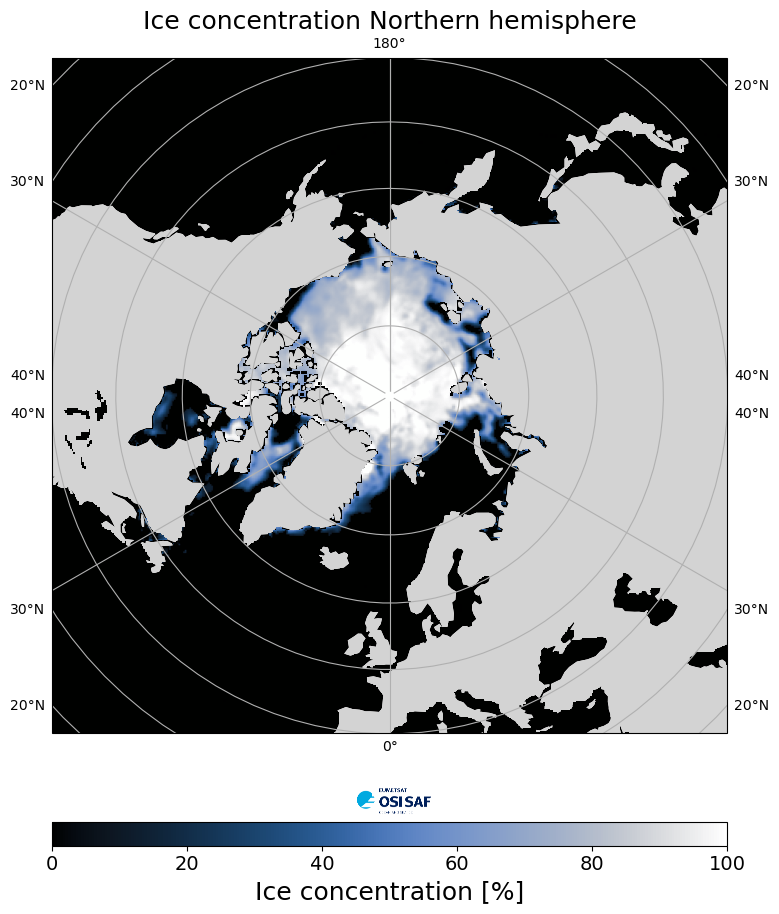

In [9]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

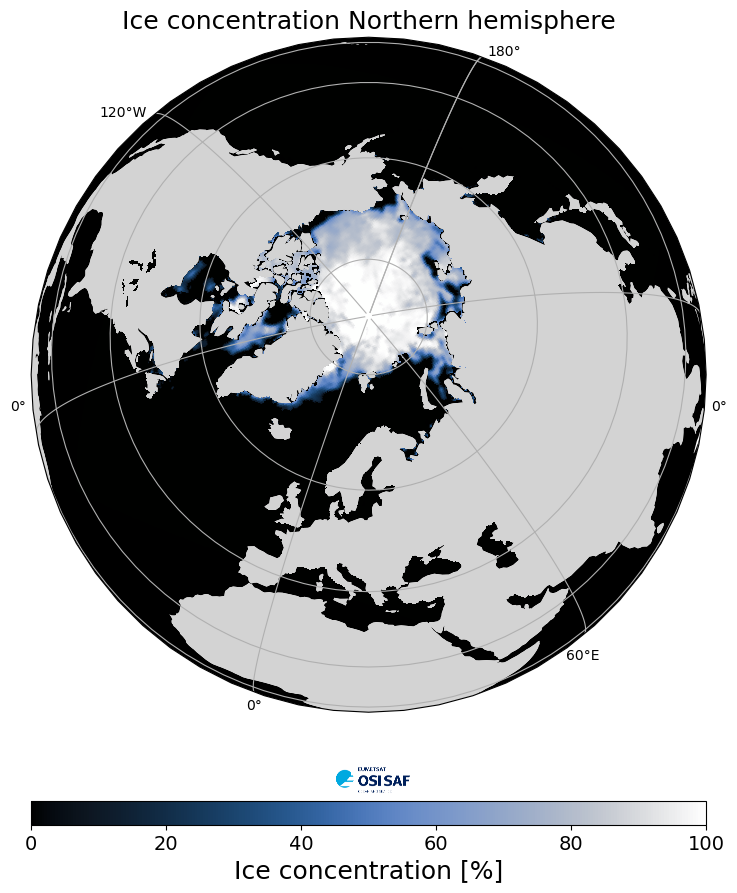

In [10]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Northern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [11]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_interim', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [12]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [13]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [14]:
nc

<xarray.Dataset> Size: 10MB
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 8B 2023-06-30T12:00:00
  * xc                              (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 746kB ...
    lon                             (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 4B ...
    time_bnds                       (time, nv) datetime64[ns] 16B ...
    ice_conc                        (time, yc, xc) float64 1MB ...
    raw_ice_conc_values             (time, yc, xc) float64 1MB ...
    total_standard_uncertainty      (time, yc, xc) float64 1MB ...
    smearing_standard_uncertainty   (time, yc, xc) float64 1MB ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 1MB ...
    status_flag                     (time, yc, xc) float32 746kB ...
Attributes: (12/43)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        -90.0
    ...                        ...
    Conventions:               CF-1.7,ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (Version 78, 21 Septemb...
    product_id:                osi-430-a
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            operational
    doi:                       10.15770/EUM_SAF_OSI_0014

Let's look at the projection information.

In [15]:
nc.variables['Lambert_Azimuthal_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   -90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0).

Let's map the data in its original projection

In [16]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Error in callback <function _draw_all_if_interactive at 0x156d3a050> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'MultiPolygon' object is not subscriptable

TypeError: 'MultiPolygon' object is not subscriptable

<Figure size 900x1200 with 3 Axes>

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [17]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [18]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Error in callback <function _draw_all_if_interactive at 0x156d3a050> (for post_execute), with arguments args (),kwargs {}:


TypeError: 'MultiPolygon' object is not subscriptable

TypeError: 'MultiPolygon' object is not subscriptable

<Figure size 900x1200 with 3 Axes>

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

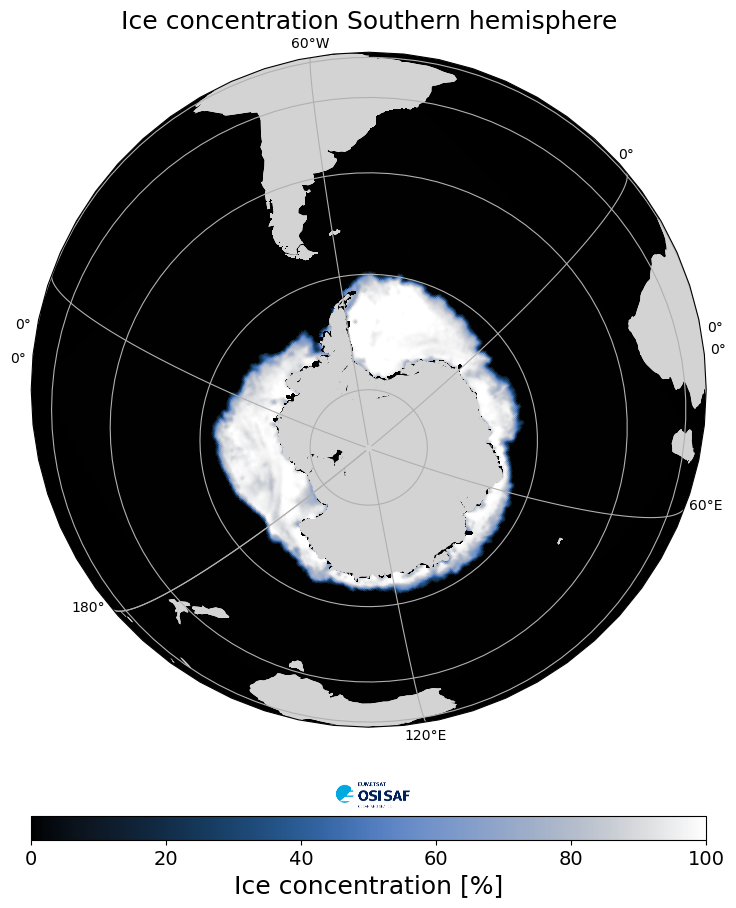

In [19]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap,
                      ice_shelves=ice_shelves, 
                      title="Ice concentration Southern hemisphere")

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)


##
<div class="alert alert-info" role="alert">

## <a id='section4'></a>5. Mapping sea ice concentration - Global Sea Ice Concentration climate data record (SMMR/SSMI/SSMIS), release 3

[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [20]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_S', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [21]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [22]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [23]:
nc

<xarray.Dataset> Size: 10MB
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 8B 2020-12-31T12:00:00
  * xc                              (xc) float64 3kB -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 3kB 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 746kB ...
    lon                             (yc, xc) float32 746kB ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 4B ...
    time_bnds                       (time, nv) datetime64[ns] 16B ...
    ice_conc                        (time, yc, xc) float64 1MB ...
    raw_ice_conc_values             (time, yc, xc) float64 1MB ...
    total_standard_uncertainty      (time, yc, xc) float64 1MB ...
    smearing_standard_uncertainty   (time, yc, xc) float64 1MB ...
    algorithm_standard_uncertainty  (time, yc, xc) float64 1MB ...
    status_flag                     (time, yc, xc) float32 746kB ...
Attributes: (12/43)
    title:                     Sea Ice Concentration Climate Data Record Vers...
    summary:                   This climate data record of sea ice concentrat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    geospatial_lat_min:        16.62393
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    ...                        ...
    algorithm:                 SICCI3LF (19V, 37V, 37H)
    references:                Product User Manual v3 (2022),Algorithm Theore...
    contributor_name:          Thomas Lavergne,Atle Soerensen,Rasmus Tonboe,C...
    contributor_role:          PrincipalInvestigator,author,author,author,aut...
    source:                    FCDR of SMMR / SSMI / SSMIS Brightness Tempera...
    product_status:            released

Let's look at the projection information.

In [24]:
nc.variables['Lambert_Azimuthal_Grid']

<xarray.Variable ()> Size: 4B
[1 values with dtype=int32]
Attributes:
    grid_mapping_name:               lambert_azimuthal_equal_area
    longitude_of_projection_origin:  0.0
    latitude_of_projection_origin:   90.0
    false_easting:                   0.0
    false_northing:                  0.0
    semi_major_axis:                 6378137.0
    inverse_flattening:              298.257223563
    proj4_string:                    +proj=laea +lon_0=0 +datum=WGS84 +ellps=...

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0).

Let's map the data in its original projection

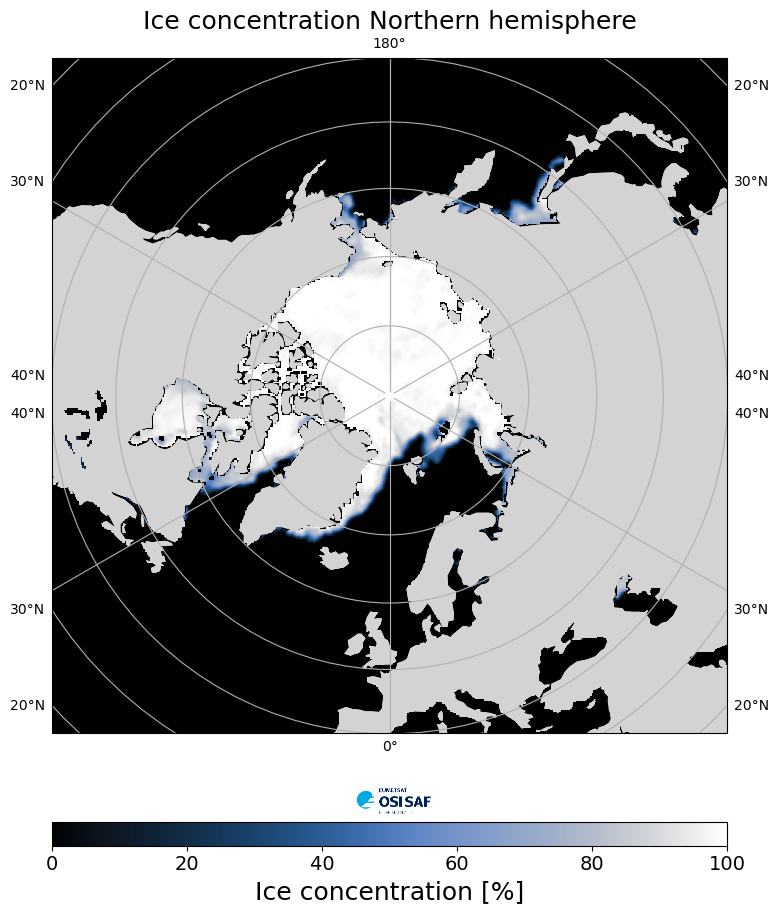

In [25]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Northern hemisphere")

# Adding colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

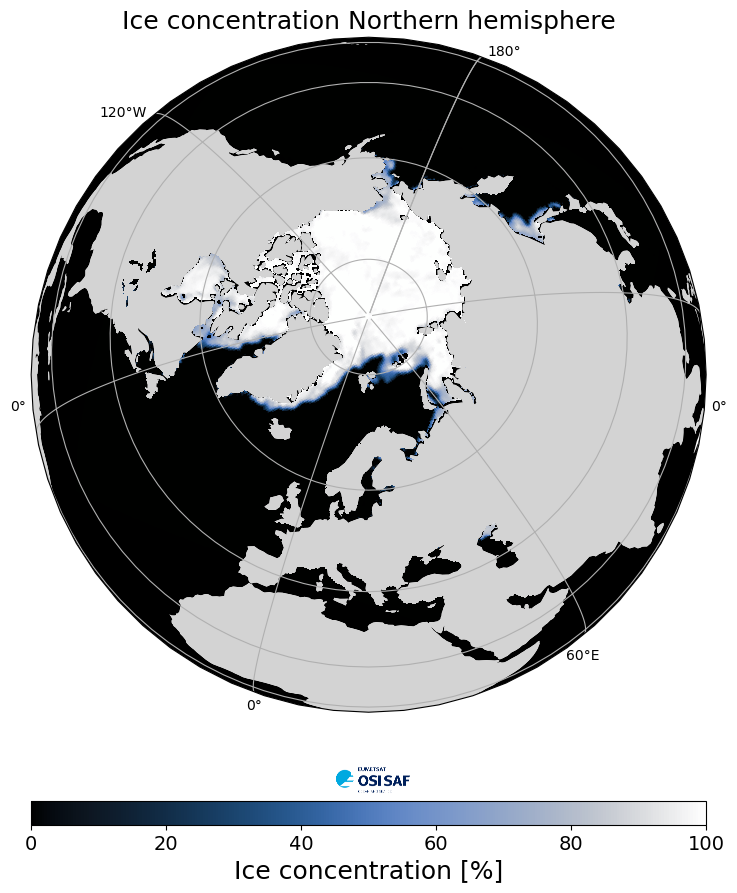

In [26]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Northern hemisphere")

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_S', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Lambert_Azimuthal_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Northern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##
<div class="alert alert-info" role="alert">

## <a id='section4'></a>6. Mapping sea ice concentration - Global Sea Ice Concentration climate data record (AMSR), release 3

[Back to top](#TOC-TOP)

</div>

### Northern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_AMSR_release', 'nh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Lambert_Azimuthal_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Northern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=90.0)
output_projection=ccrs.Orthographic(20,80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Northern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

### Southern hemisphere

Setting directory where to read data files

In [ ]:
directory = os.path.join(os.getcwd(), 'products', 'sea_ice_conc_AMSR_release', 'sh')

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>.   
However, we recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> or that you use scientific colormaps for data visulaisation from librairies such as cmcrameri.

In [ ]:
#cmap = cmocean.cm.ice
cmap = cmcrameri.cm.oslo

Sea Ice concentration data has a specific projection. We can explore the netcdf file to find the characteristics.

In [ ]:
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename))

In [ ]:
nc

Let's look at the projection information.

In [ ]:
nc.variables['Lambert_Azimuthal_Grid']

You should be able see the 'proj4_string', it provides us with the information needed to define the cartopy projection setting of our input data :  
* +proj=laea +lon_0=0 +datum=WGS84 +ellps=WGS84 +lat_0=-90.0   

Which we will translate into ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0).

Let's map the data in its original projection

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

You should notice on the figure above, that there are missing areas of data around the Antarctic continent. These correspond to Ice Shelves that are not included directly in cartopy LAND boundaries. So let's add them to the plot.

In [ ]:
ice_shelves = cfeature.NaturalEarthFeature(
        category='physical',
        name='antarctic_ice_shelves_polys',
        scale='10m',
        facecolor='lightgrey',
        edgecolor='lightgrey')

Plot with Ice Shelves.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

Other type of mapping projection can be use to visualize products. All the map projection are available in the  <a href="https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html" target="_blank">cartopy documenation</a> 
Reproject the data in an orthographic view.
Reproject the data in an orthographic view.

In [ ]:
# Create a new figure
fig = plt.figure(figsize=(9,12))

# Map Sea Ice concentration
data_projection=ccrs.LambertAzimuthalEqualArea(central_longitude=0.0, central_latitude=-90.0)
output_projection=ccrs.Orthographic(-50,-80)
im = mapping_ice_conc(directory, 
                      data_projection, 
                      output_projection, 
                      cmap=cmap, 
                      ice_shelves=ice_shelves,
                      title="Ice concentration Southern hemisphere")

add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_sea_ice_file_structure.ipynb" target="_blank"><< Exploring OSI SAF sea ice file structure</a>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="./1_3b_OSI_SAF_sea_ice_mapping_ice_edge.ipynb" target="_blank">Mapping OSI SAF sea ice edge >></a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>